In [8]:
import scanpy as sc
import graph_tool.all as gt
import schist
import seaborn as sns
import pandas as pd
import anndata
import pickle
import mygene
import scipy.stats
import statsmodels.api as sm
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [9]:
adata=sc.read('../../scRNA_paga/state_adata/10XV3_minimize.h5ad')

In [41]:
adata=sc.read('../../scRNA_paga/state_adata/10XV3_equilibrate.h5ad')

In [7]:
sc.settings.set_figure_params(dpi=300, facecolor='white')

<BarContainer object of 10 artists>

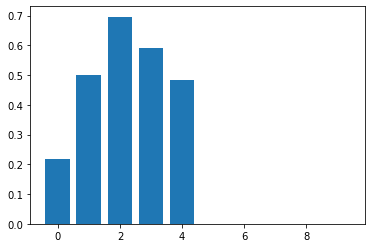

In [3]:
modularity=[x for x in adata.uns['nsbm']['stats']['modularity']]
levels=[x for x in range(len(modularity))]
bar(levels,modularity)

In [89]:
M=adata.uns['nsbm']['cell_affinity']['1']
adata.obs['max_u'] = 1 - np.max(M, axis=1)

In [95]:
adata_affinity=adata[adata.obs.max_u < 1e-10]

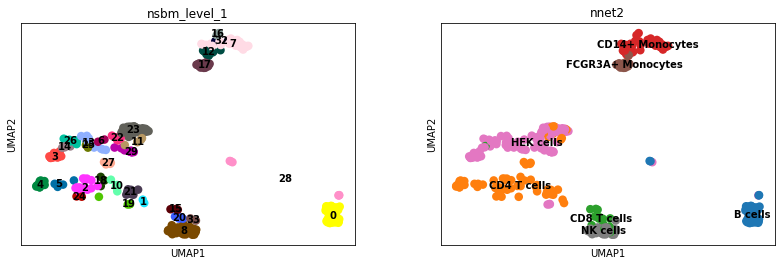

In [96]:
sc.pl.umap(adata_affinity,color=['nsbm_level_1','nnet2'], legend_loc='on data')

In [36]:
sc.tl.leiden(adata, resolution=0.74)

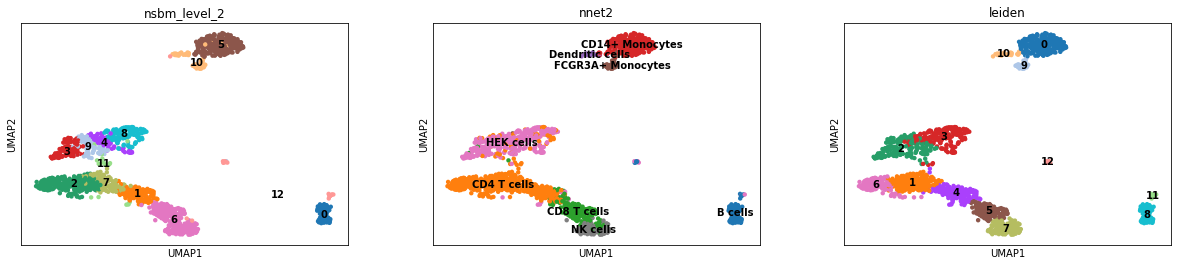

In [224]:
sc.pl.umap(adata,color=['nsbm_level_2','nnet2','leiden'],legend_loc='on data')

In [221]:
level = '2'
marginals = adata.uns['nsbm']['cell_affinity'][level] 
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
Max = marginals[marginals < 1].max()
Min = marginals[marginals > 0].min()
thr = np.linspace(Min, Max, 10)
thr = np.array([ 10**-x for x in range(0, 11)])

In [222]:
n_cell = adata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
cell_aff = np.max(marginals, axis=1)

D = np.array([adata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])

p = D / n_cell
p = p.T

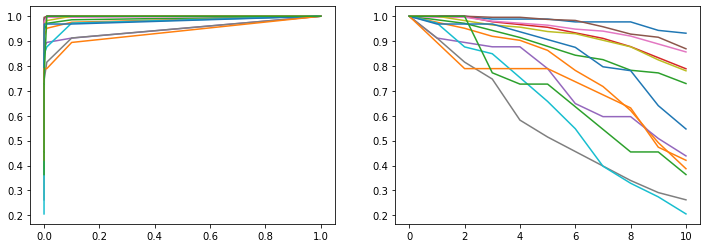

In [223]:
figure(figsize=(12, 4))
subplot(1,2,1)
for x in p:
    plot( thr,x)
subplot(1,2,2)
for x in p:
    plot(x)

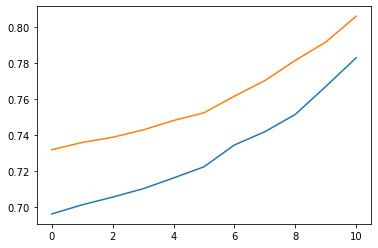

In [175]:
import sklearn
thr = np.array([ 10**-x for x in range(0, 11)])
mi_nsbm=list()
mi_leiden=list()
for i in thr:
    subdata=adata[adata.obs.max_u < i]
    mi_nsbm.append(sklearn.metrics.adjusted_mutual_info_score(subdata.obs.nsbm_level_2, subdata.obs.nnet2))
    mi_leiden.append(sklearn.metrics.adjusted_mutual_info_score(subdata.obs.leiden, subdata.obs.nnet2))
plot(mi_nsbm)
plot(mi_leiden)

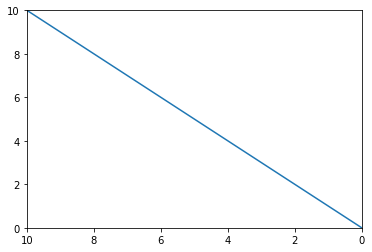

In [40]:
fig, ax = subplots(ncols=1)
ax.set_xlim([10,0])
ax.set_ylim([0, 10])


x = np.linspace(*ax.get_xlim())
ax.plot(x, x)



In [176]:
p[0]

array([1.        , 1.        , 1.        , 0.98863636, 0.98863636,
       0.98863636, 0.97727273, 0.97727273, 0.97727273, 0.94318182,
       0.93181818])

In [177]:
median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])

In [94]:
mean(p[8]-median)

0.2849040867389492

In [5]:
edata=adata

In [115]:
edata.obs['flat']=edata.obs.nsbm_level_2=='0'

In [117]:
edata.obs.flat

10X2x5K_64221_AAACCTGCACTTCGAA     True
10X2x5K_64221_AAACCTGCAGTACACT    False
10X2x5K_64221_AAACCTGTCCACTGGG    False
10X2x5K_64221_AAACGGGAGGTGGGTT    False
10X2x5K_64221_AAACGGGCACACGCTG    False
                                  ...  
10X2x5K_64221_TTTGGTTAGCGTAGTG    False
10X2x5K_64221_TTTGGTTGTGTGTGCC    False
10X2x5K_64221_TTTGTCACACGGACAA    False
10X2x5K_64221_TTTGTCACATTCTCAT    False
10X2x5K_64221_TTTGTCAGTCTAGGTT    False
Name: flat, Length: 1523, dtype: bool

In [152]:
a=pd.Series(edata.obs.nsbm_level_2[edata.obs.nsbm_level_2=='0'], index=edata.obs.nsbm_level_2.index[edata.obs.nsbm_level_2=='0'])

In [154]:
a=a.replace(group_names[0],str(level+'_'+group_names[0]))

In [155]:
a

10X2x5K_64221_AAACCTGCACTTCGAA    2_0
10X2x5K_64221_AACGTTGCAGCTGTTA    2_0
10X2x5K_64221_AACTCCCCAATTGCTG    2_0
10X2x5K_64221_AAGACCTGTCAATGTC    2_0
10X2x5K_64221_ACAGCTACAGCTCGCA    2_0
                                 ... 
10X2x5K_64221_TTAGGCAGTTGCGTTA    2_0
10X2x5K_64221_TTAGTTCCAAAGAATC    2_0
10X2x5K_64221_TTCTACAAGTAGCCGA    2_0
10X2x5K_64221_TTTGCGCGTCGACTAT    2_0
10X2x5K_64221_TTTGCGCGTCGGCATC    2_0
Name: nsbm_level_2, Length: 88, dtype: category
Categories (13, object): [2_0, 1, 2, 3, ..., 9, 10, 11, 12]

In [127]:
b=pd.Series(edata.obs.nsbm_level_2[edata.obs.nsbm_level_2=='1'], index=edata.obs.nsbm_level_2.index[edata.obs.nsbm_level_2=='1'])

In [128]:
pd.Series.append(a, b, ignore_index=False, verify_integrity=True)

10X2x5K_64221_AAACCTGCACTTCGAA    0
10X2x5K_64221_AACGTTGCAGCTGTTA    0
10X2x5K_64221_AACTCCCCAATTGCTG    0
10X2x5K_64221_AAGACCTGTCAATGTC    0
10X2x5K_64221_ACAGCTACAGCTCGCA    0
                                 ..
10X2x5K_64221_TTAGTTCTCTGTCTAT    1
10X2x5K_64221_TTCTACATCACGACTA    1
10X2x5K_64221_TTCTCCTCAGTCTTCC    1
10X2x5K_64221_TTGAACGCAAAGCGGT    1
10X2x5K_64221_TTGCCGTAGCACCGCT    1
Name: nsbm_level_2, Length: 212, dtype: category
Categories (13, object): [0, 1, 2, 3, ..., 9, 10, 11, 12]

In [202]:
edata=adata

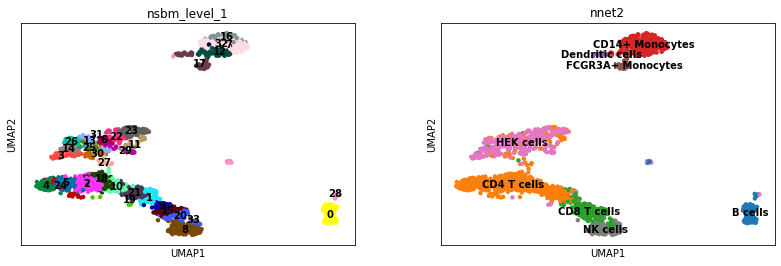

In [205]:
sc.pl.umap(edata, color=['nsbm_level_1','nnet2'],legend_loc='on data')

In [157]:
flat=pd.Series()
flat

<ipython-input-157-07ac5743dac5>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()


Series([], dtype: float64)

In [38]:
cdata=adata.copy()
flat=pd.Series()

<ipython-input-38-e9aa9f4cb1b4>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()


In [39]:
for i in range(1,len(cdata.uns['nsbm']['cell_affinity'])):
    level = str(i)
    marginals = cdata.uns['nsbm']['cell_affinity'][level] 
    group_names = cdata.obs[f'nsbm_level_{level}'].cat.categories
    Max = marginals[marginals < 1].max()
    Min = marginals[marginals > 0].min()
    thr = np.linspace(Min, Max, 10)
    thr = np.array([ 10**-x for x in range(0, 11)])
    n_cell = cdata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
    cell_aff = np.max(marginals, axis=1)
    D = np.array([cdata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])
    p = D / n_cell
    p = p.T
    median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])
    del_aff=[]
    for group in group_names:
        group_sign=mean(p[int(group)]-median)
        if group_sign>0.25:
            a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==group], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==group])
            a=a.replace(group,str(level+'_'+group))
            flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
            del_affinities_g=[x for x in range(len(cdata.obs[f'nsbm_level_{level}'])) if cdata.obs[f'nsbm_level_{level}'][x]==group]
            del_aff.append(del_affinities)
            cdata=cdata[cdata.obs[f'nsbm_level_{level}']!=group]
    for i in cdata.uns['nsbm']['cell_affinity']:
        cdata.uns['nsbm']['cell_affinity'][i]=np.delete(cdata.uns['nsbm']['cell_affinity'][i], del_aff,axis=0)
           
            


IndexError: Boolean index does not match AnnData’s shape along this dimension. Boolean index has shape (1399,) while AnnData index has shape (1110,).

In [41]:
cdata.obs[f'nsbm_level_{level}']!=group

10X2x5K_64221_AAACCTGCAGTACACT    True
10X2x5K_64221_AAACCTGTCCACTGGG    True
10X2x5K_64221_AAACGGGCACACGCTG    True
10X2x5K_64221_AAACGGGCACCAGCAC    True
10X2x5K_64221_AAACGGGGTGAAAGAG    True
                                  ... 
10X2x5K_64221_TTTGCGCCATCAGTAC    True
10X2x5K_64221_TTTGGTTAGCGTAGTG    True
10X2x5K_64221_TTTGTCACACGGACAA    True
10X2x5K_64221_TTTGTCACATTCTCAT    True
10X2x5K_64221_TTTGTCAGTCTAGGTT    True
Name: nsbm_level_2, Length: 1110, dtype: bool

In [25]:
del_affinities=[x for x in range(len(cdata.obs[f'nsbm_level_{level}'])) if cdata.obs[f'nsbm_level_{level}'][x]=='1']

In [42]:
flat

10X2x5K_64221_AAACCTGCACTTCGAA     1_0
10X2x5K_64221_AACGTTGCAGCTGTTA     1_0
10X2x5K_64221_AACTCCCCAATTGCTG     1_0
10X2x5K_64221_AAGACCTGTCAATGTC     1_0
10X2x5K_64221_ACAGCTACAGCTCGCA     1_0
                                  ... 
10X2x5K_64221_CGGACTGTCCATGCTC    1_32
10X2x5K_64221_GTGCTTCGTCACCTAA    1_32
10X2x5K_64221_TGAGCATGTTCTCATT    1_32
10X2x5K_64221_CGGTTAATCCAAAGTC    1_33
10X2x5K_64221_GTTCTCGAGTGGAGAA    1_33
Length: 413, dtype: object

In [17]:
cdata=adata
flat=pd.Series()
level = str(2)
marginals = cdata.uns['nsbm']['cell_affinity'][level] 
group_names = cdata.obs[f'nsbm_level_{level}'].cat.categories
Max = marginals[marginals < 1].max()
Min = marginals[marginals > 0].min()
thr = np.linspace(Min, Max, 10)
thr = np.array([ 10**-x for x in range(0, 11)])
n_cell = cdata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
cell_aff = np.max(marginals, axis=1)
D = np.array([cdata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])
p = D / n_cell
p = p.T
median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])
for group in group_names:
    group_sign=mean(p[int(group)]-median)
    if group_sign>0.25:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==group], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==group])
        a=a.replace(group,str(level+'_'+group))
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        del_affinities=[x for x in range(len(cdata.obs[f'nsbm_level_{level}'])) if cdata.obs[f'nsbm_level_{level}'][x]==group]
        for i in cdata.uns['nsbm']['cell_affinity']:
            cdata.uns['nsbm']['cell_affinity'][i]=np.delete(cdata.uns['nsbm']['cell_affinity'][i], del_affinities,axis=0)
        cdata=cdata[cdata.obs[f'nsbm_level_{level}']!=group]
            
adata.obs['flat']=flat
sc.pl.umap(adata, color=['flat','nnet2',f'nsbm_level_{level}'])
#sns.barplot(data=-log10(marginals))
fdata=adata
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs, scale='width')

<ipython-input-17-bdab5851a3cb>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()


IndexError: Boolean index does not match AnnData’s shape along this dimension. Boolean index has shape (1435,) while AnnData index has shape (1523,).

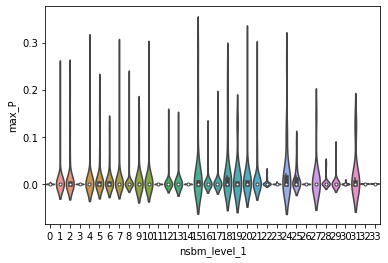

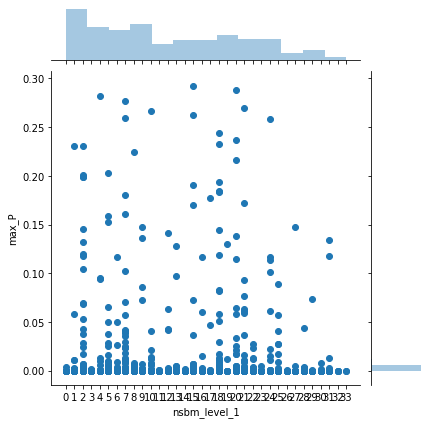

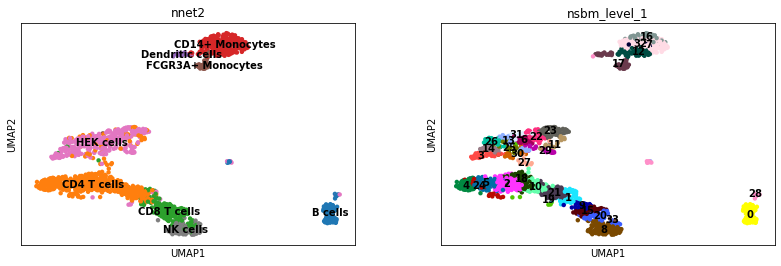

In [15]:
fdata=adata
level=str(1)
marginals = fdata.uns['nsbm']['cell_affinity'][level] 
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs,scale='width')
sns.jointplot(x=f'nsbm_level_{level}' , y='max_P', data=fdata.obs)
sc.pl.umap(adata, color=['nnet2',f'nsbm_level_{level}'],legend_loc='on data')

In [5]:
import seaborn as sns


In [47]:
fdata=adata

In [50]:
fdata=adata
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.barplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs)

ValueError: Length of values does not match length of index

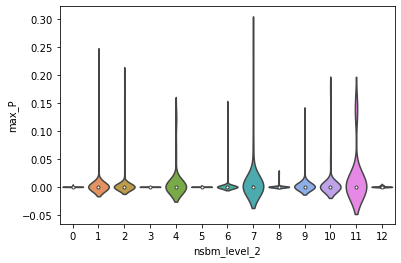

In [8]:
fdata=adata
fdata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = fdata.obs, scale='width')

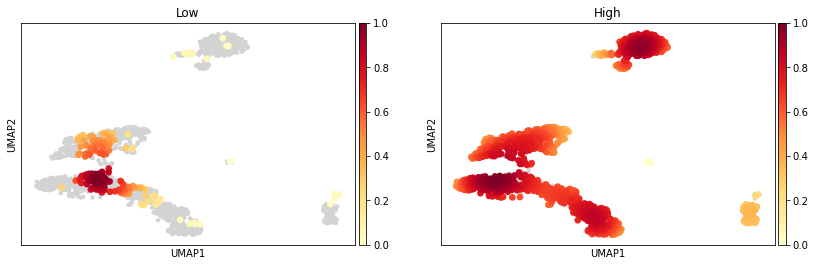

In [16]:
fdata=adata
level=str(2)
marginals = fdata.uns['nsbm']['cell_affinity'][level] 
d = pd.Categorical(np.max(marginals, axis=1) > (1 - 1e-5))
d.rename_categories(['Low', 'High'], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')

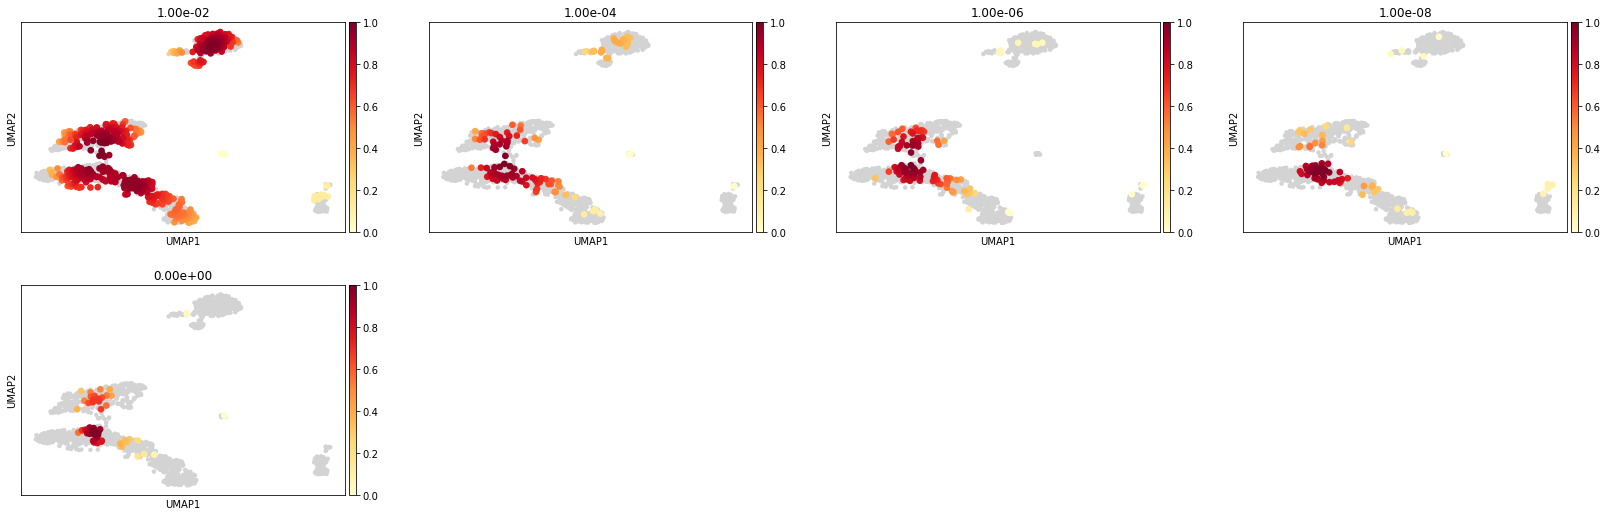

In [195]:
cuts = [0]+ [10**-x for x in range(0, 10, 2)][::-1]
d = pd.Categorical(pd.cut(1-np.max(marginals, axis=1), cuts))
d.rename_categories([f'{x:.2e}' for x in cuts[:-1]][::-1], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')

In [42]:
cdata=adata.copy()
flat=pd.Series()

<ipython-input-42-e9aa9f4cb1b4>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()


... storing 'flat' as categorical


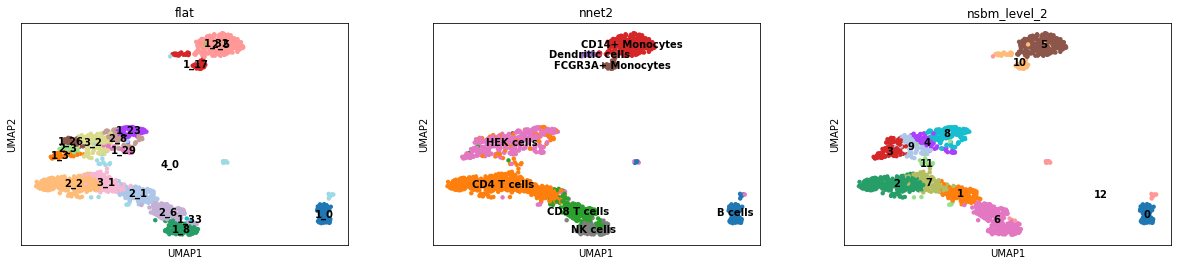

In [40]:
for i in range(1,len(cdata.uns['nsbm']['cell_affinity'])):
    level = str(i)
    marginals = cdata.uns['nsbm']['cell_affinity'][level] 
    group_names = cdata.obs[f'nsbm_level_{level}'].cat.categories
    try:
        Max = marginals[marginals < 1].max()
        Min = marginals[marginals > 0].min()
        thr = np.linspace(Min, Max, 10)
        thr = np.array([ 10**-x for x in range(0, 11)])
        n_cell = cdata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
        cell_aff = np.max(marginals, axis=1)
        D = np.array([cdata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])
        p = D / n_cell
        p = p.T
        median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])
        for group in group_names:
            group_sign=mean(p[int(group)]-median)
            if group_sign>0.25:
                a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==group], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==group])
                a=a.replace(group,str(level+'_'+group))
                flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=False)
    except ValueError: 
        continue
flat = flat.loc[~flat.index.duplicated(keep='first')]
adata.obs['flat']=flat
sc.pl.umap(adata, color=['flat','nnet2','nsbm_level_2'],legend_loc='on data')

... storing 'flat' as categorical


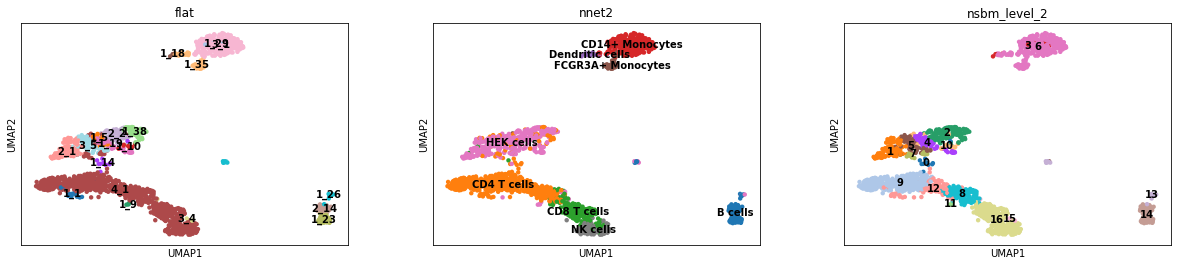

In [43]:
for i in range(1,len(cdata.uns['nsbm']['cell_affinity'])):
    level = str(i)
    marginals = cdata.uns['nsbm']['cell_affinity'][level] 
    group_names = cdata.obs[f'nsbm_level_{level}'].cat.categories
    try:
        Max = marginals[marginals < 1].max()
        Min = marginals[marginals > 0].min()
        thr = np.linspace(Min, Max, 10)
        thr = np.array([ 10**-x for x in range(0, 11)])
        n_cell = cdata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
        cell_aff = np.max(marginals, axis=1)
        D = np.array([cdata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])
        p = D / n_cell
        p = p.T
        median=np.array([1,0.9,0.8,0.7,0.6,0.6,0.4,0.3,0.2,0.1,0])
        for group in group_names:
            group_sign=mean(p[int(group)]-median)
            if group_sign>0:
                a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==group], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==group])
                a=a.replace(group,str(level+'_'+group))
                flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=False)
    except ValueError: 
        continue
flat = flat.loc[~flat.index.duplicated(keep='first')]
adata.obs['flat']=flat
sc.pl.umap(adata, color=['flat','nnet2','nsbm_level_2'],legend_loc='on data')